In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
notebook = "real1_Abalone_init_temp3"

In [3]:
import numpy as np

from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
abalone = fetch_ucirepo(id=1)
  
# data (as pandas dataframes) 
X = abalone.data.features 
y = abalone.data.targets 
X = X.drop(columns=['Sex'])

In [4]:
X = X.values.astype(float)
y = np.array(y).reshape(-1)

In [5]:
ndpost = 10000
nskip = 0
n_trees = 100

In [6]:
from experiment_init import run_parallel_experiments

# Run 5 parallel experiments
results = run_parallel_experiments(X, y, ndpost, nskip, n_trees, notebook, 
                                   temperature=3.0, # Only for default sampler, not used in mtmh
                                   n_runs=5, n_jobs=-2, store_preds=True, 
                                   n_test_points=100, # Store all test points if not specified
                                   n_chains=4)

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done   2 out of   5 | elapsed: 151.8min remaining: 227.7min
[Parallel(n_jobs=-2)]: Done   3 out of   5 | elapsed: 156.4min remaining: 104.2min
[Parallel(n_jobs=-2)]: Done   5 out of   5 | elapsed: 158.4min finished


In [6]:
import numpy as np

experiment_results = np.load(f'store/{notebook}.npz', allow_pickle=True)

default_data = experiment_results['default'].item()
mtmh_data = experiment_results['mtmh'].item()
metadata = experiment_results['metadata'].item()

n_runs = metadata['n_runs']

# Trace Plot

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def plot_moves_and_pca(
    accepted_moves_logmh, preds, threshold=1, agg_method='min', n_components=5, chain_id=0
):
    """
    Plot exp(log_mh) (min or median per iteration) for each move and PCA 1st component.
    Args:
        accepted_moves_logmh: shape [n_runs, n_chains, ...]
        preds: shape [n_runs, n_chains, n_test_points, n_iter]
        threshold: float, max value for exp(log_mh) to plot (default 1)
        agg_method: 'min' or 'median' for log_mh aggregation per iteration
        n_components: int, number of PCA components
        chain_id: int, which chain to use
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.decomposition import PCA
    n_runs = accepted_moves_logmh.shape[0]
    # 1. Summarize all unique moves across all runs and iterations
    all_moves_set = set()
    for run_id in range(n_runs):
        moves_per_iter = accepted_moves_logmh[run_id, chain_id]
        for moves in moves_per_iter:
            if len(moves) == 0:
                continue
            move_keys = [m[0] for m in moves]
            all_moves_set.update(move_keys)
    all_moves = sorted(list(all_moves_set))  # Ensure consistent order
    # 2. Define colors for each move
    colors = plt.cm.tab10(np.linspace(0, 1, len(all_moves)))
    move2color = {m: colors[i] for i, m in enumerate(all_moves)}
    # 3. Plotting
    for run_id in range(n_runs):
        moves_per_iter = accepted_moves_logmh[run_id, chain_id]
        iters = []
        log_mh_vals = []
        move_names = []
        for i, moves in enumerate(moves_per_iter):
            if len(moves) == 0:
                continue
            move_keys = [m[0] for m in moves]
            log_mhs = [m[1] for m in moves]
            if agg_method == 'min':
                idx = np.argmin(log_mhs)
                agg_val = log_mhs[idx]
                move_name = move_keys[idx]
            elif agg_method == 'median':
                agg_val = np.median(log_mhs)
                move_name = move_keys[0]  # representative
            else:
                raise ValueError("agg_method must be 'min' or 'median'")
            iters.append(i)
            log_mh_vals.append(agg_val)
            move_names.append(move_name)
        # PCA on predictions
        chain_preds = preds[run_id, chain_id].T
        chain_preds_centered = chain_preds - np.mean(chain_preds, axis=0)
        pca = PCA(n_components=n_components)
        chain_preds_pca = pca.fit_transform(chain_preds_centered)
        pc1 = chain_preds_pca[:, 0]
        fig, ax1 = plt.subplots(figsize=(12, 5))
        for m in all_moves:
            idxs = [i for i, mv in enumerate(move_names) if mv == m]
            filtered = [(iters[i], min(np.exp(log_mh_vals[i]), 1)) for i in idxs if min(np.exp(log_mh_vals[i]), 1) <= threshold]
            if not filtered:
                continue
            x_vals, y_vals = zip(*filtered)
            ax1.scatter(x_vals, y_vals, color=move2color[m], label=m, s=18)
        ax1.set_xlabel('Iteration')
        ax1.set_ylabel(f'exp(log_mh) ({agg_method} per iteration)')
        ax1.legend(loc='upper left')
        ax1.grid(alpha=0.3)
        ax2 = ax1.twinx()
        ax2.plot(range(len(pc1)), pc1, color='black', label='PCA 1st component', linewidth=1.5, alpha=0.7)
        ax2.set_ylabel('PCA 1st component')
        ax2.legend(loc='upper right')
        plt.title(f'Run {run_id}, Chain {chain_id}: {agg_method} exp(log_mh) per iteration & PCA1')
        plt.tight_layout()
        plt.show()

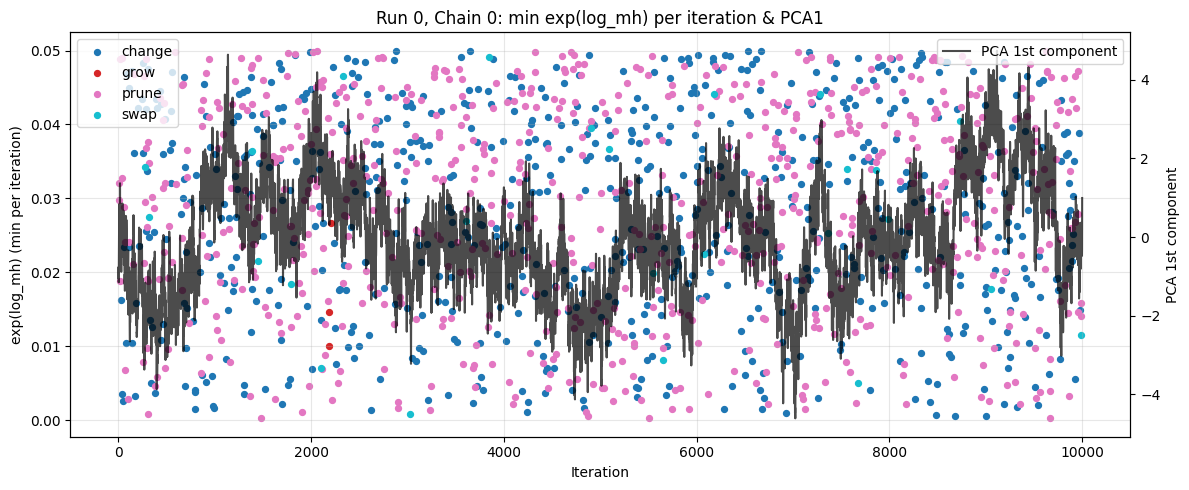

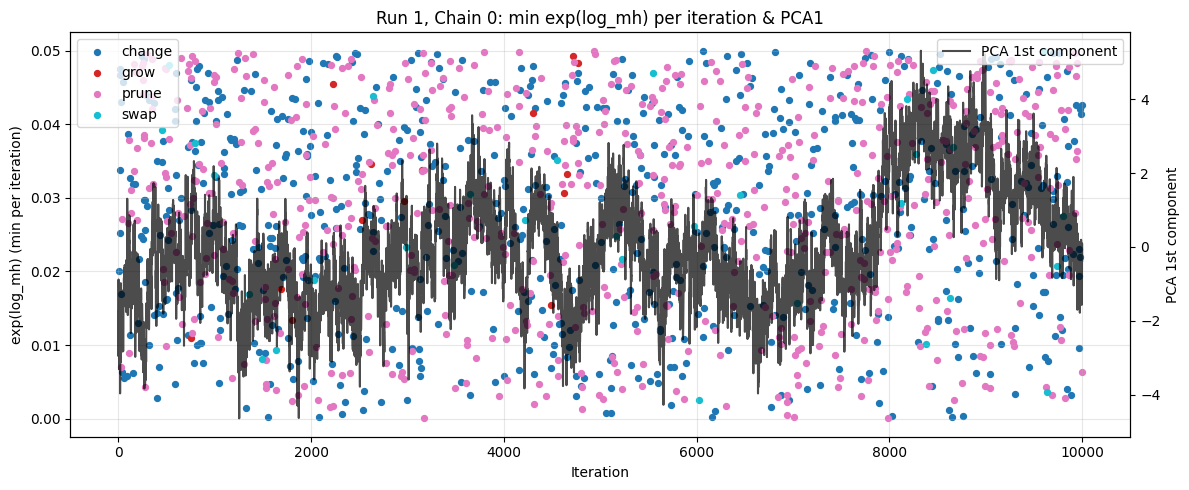

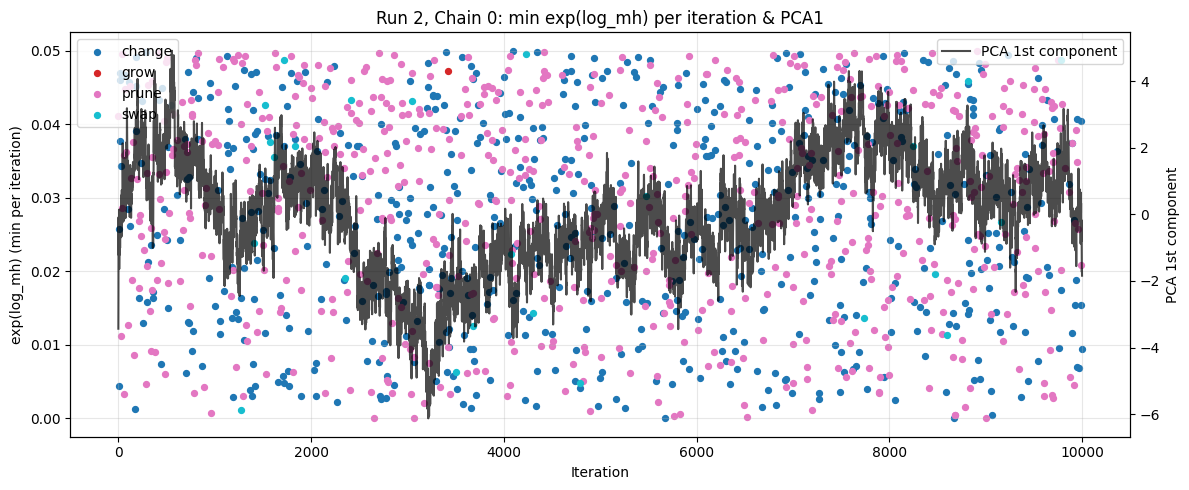

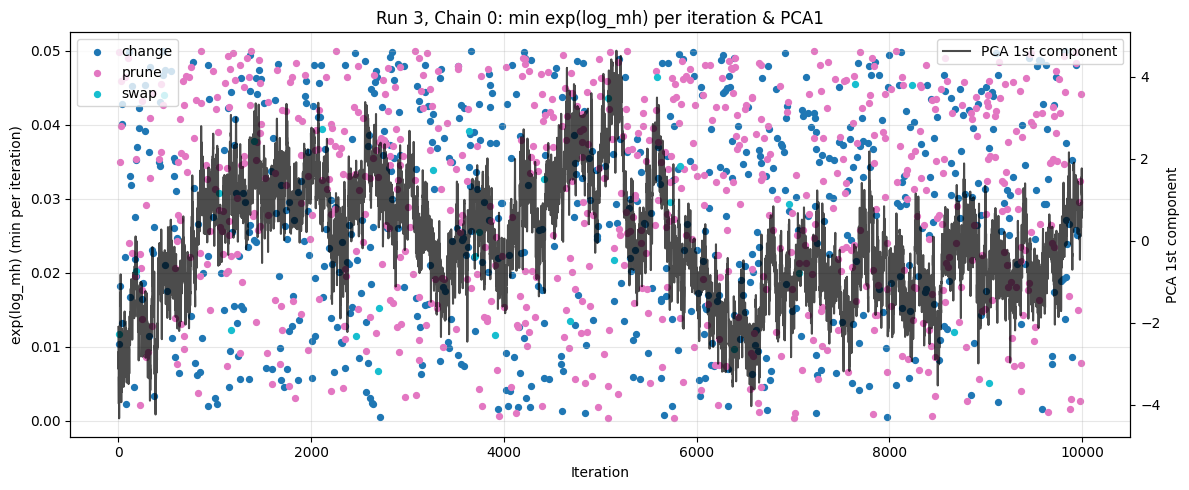

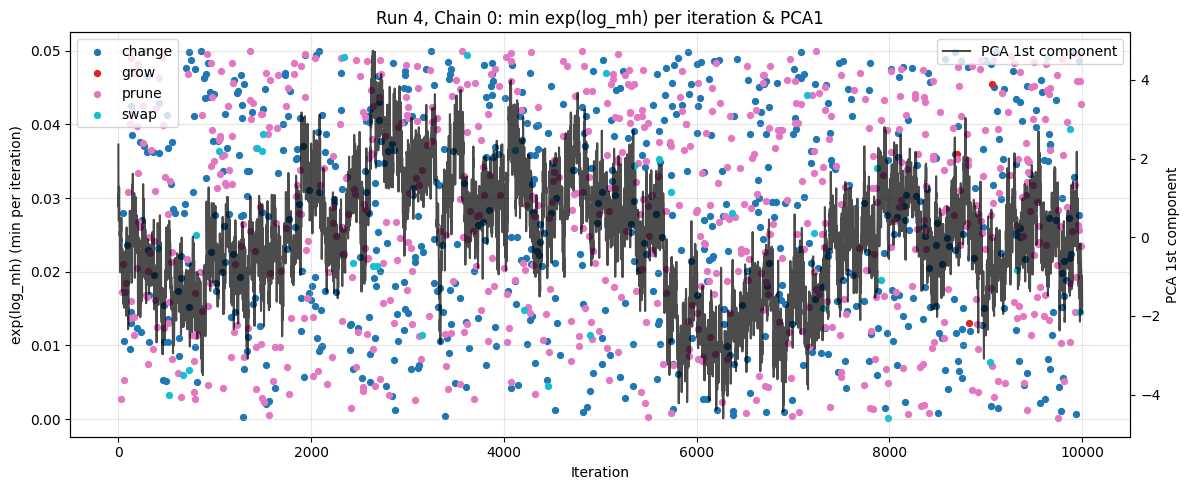

In [9]:
experiment_results = np.load(f'store/{notebook}.npz', allow_pickle=True)
default_data = experiment_results['default'].item()
accepted_moves_logmh = default_data['accepted_moves_logmh']
preds = default_data['preds']

plot_moves_and_pca(
    accepted_moves_logmh,
    preds,
    threshold=0.05,
    agg_method='min',
    n_components=5,
    chain_id=0
)

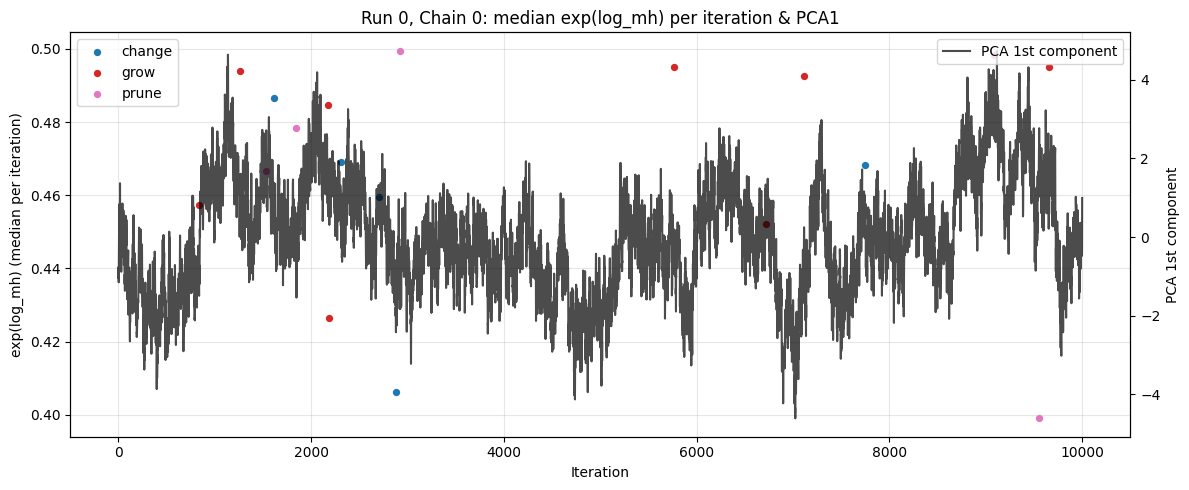

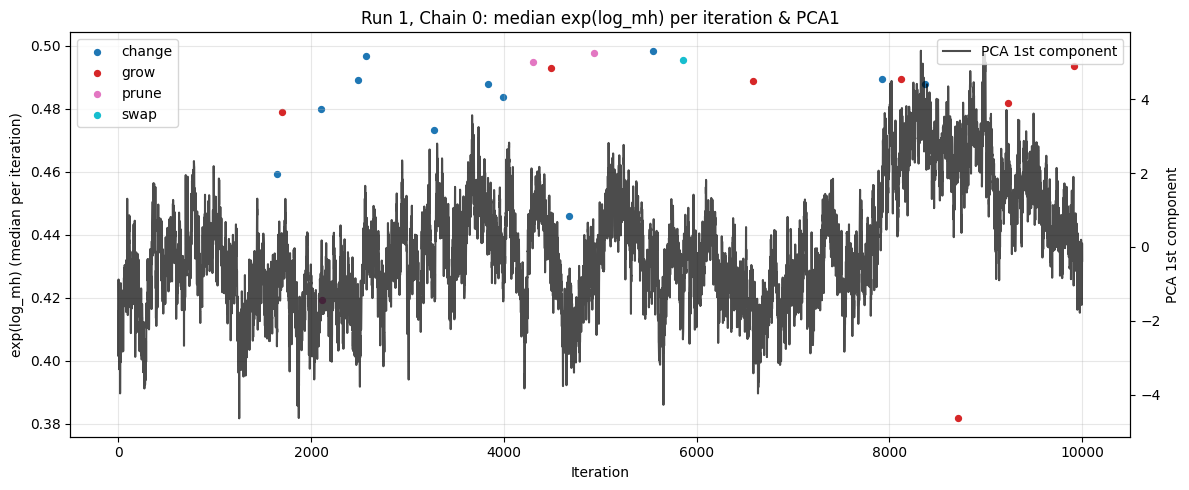

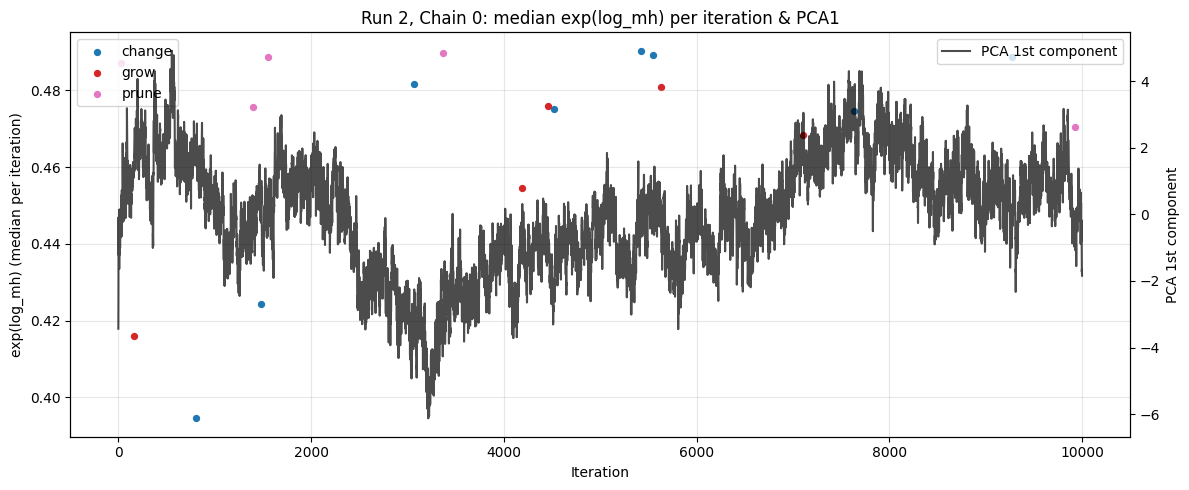

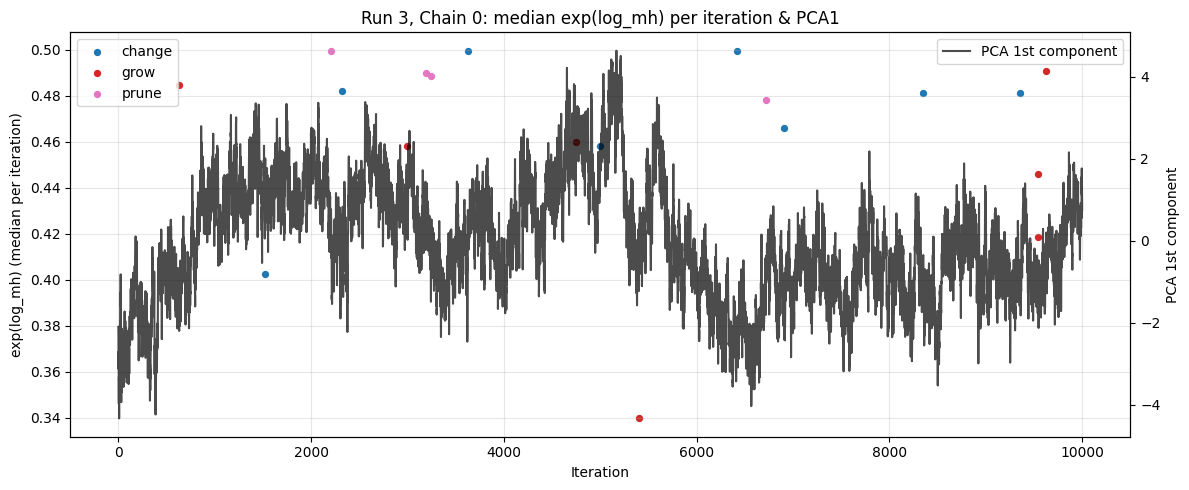

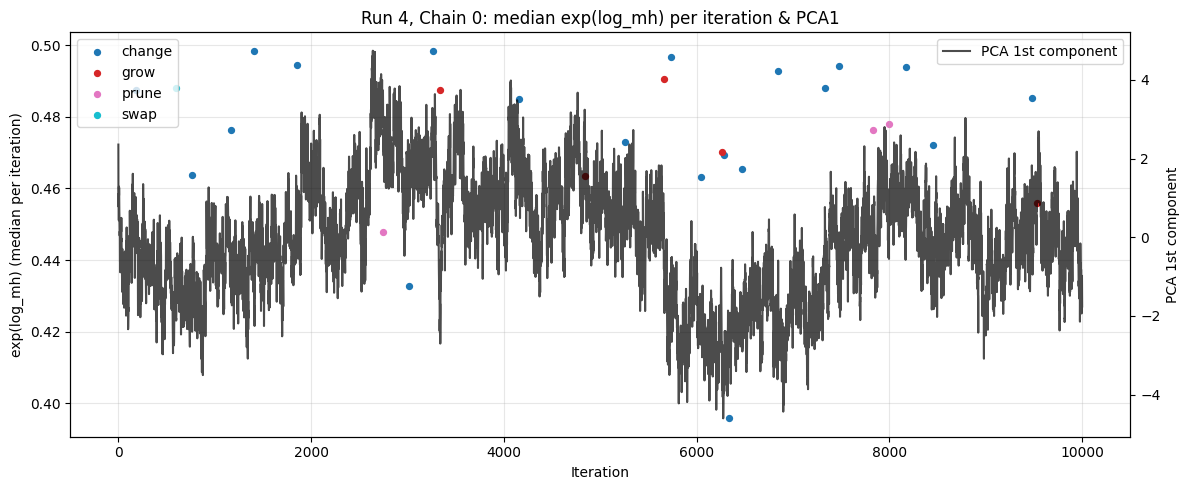

In [10]:
experiment_results = np.load(f'store/{notebook}.npz', allow_pickle=True)
default_data = experiment_results['default'].item()
accepted_moves_logmh = default_data['accepted_moves_logmh']
preds = default_data['preds']

plot_moves_and_pca(
    accepted_moves_logmh,
    preds,
    threshold=0.5,
    agg_method='median',
    n_components=5,
    chain_id=0
)

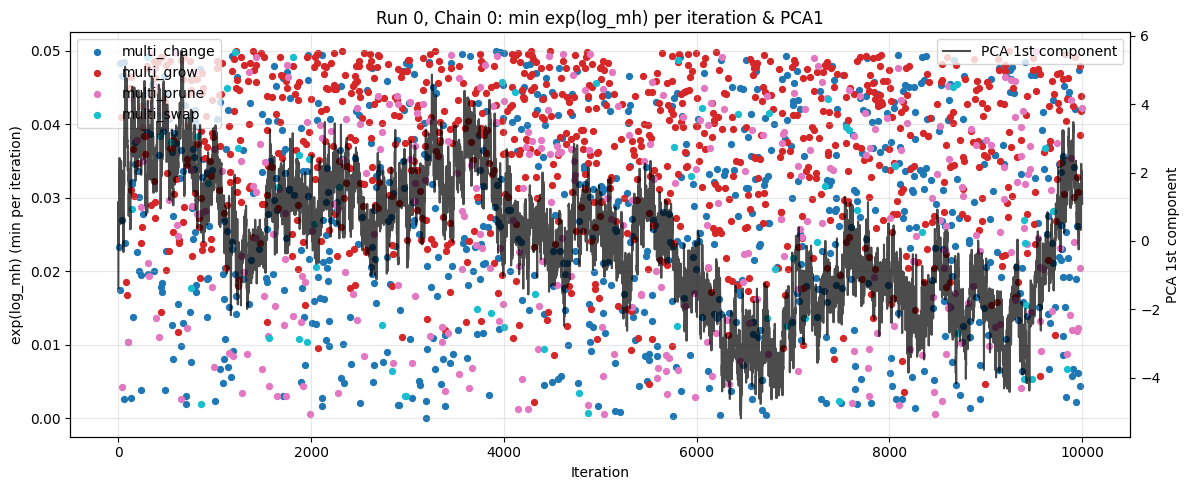

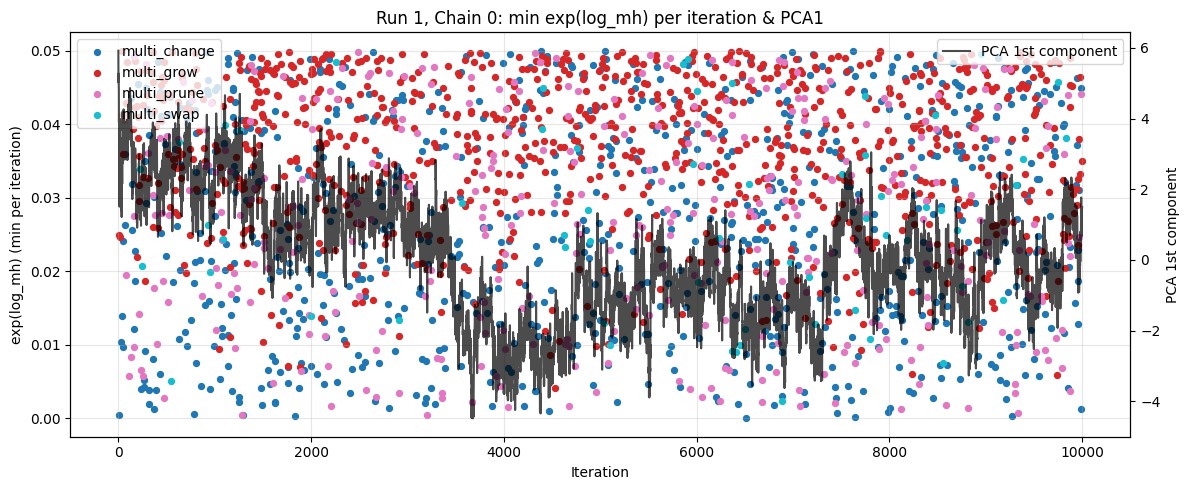

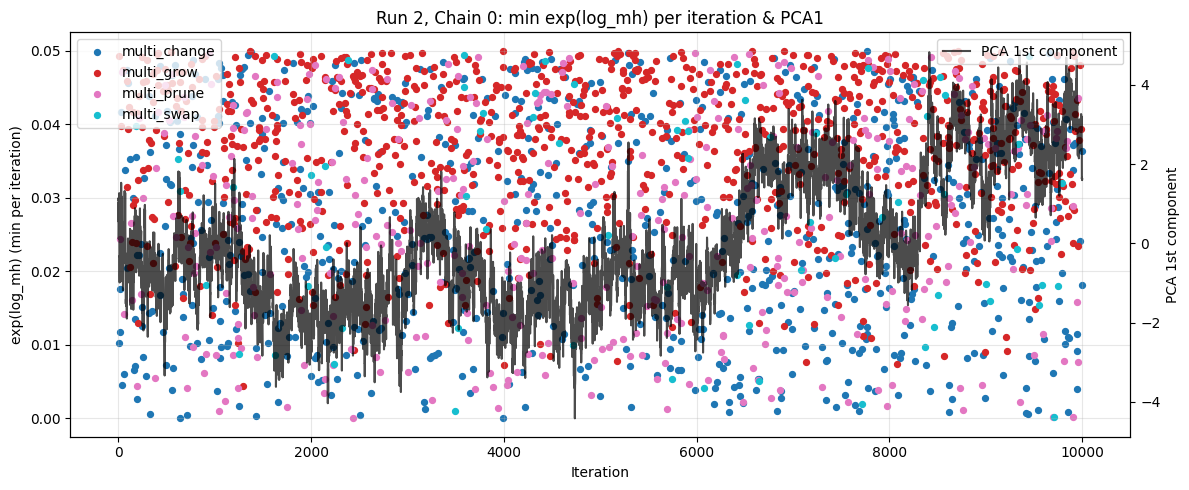

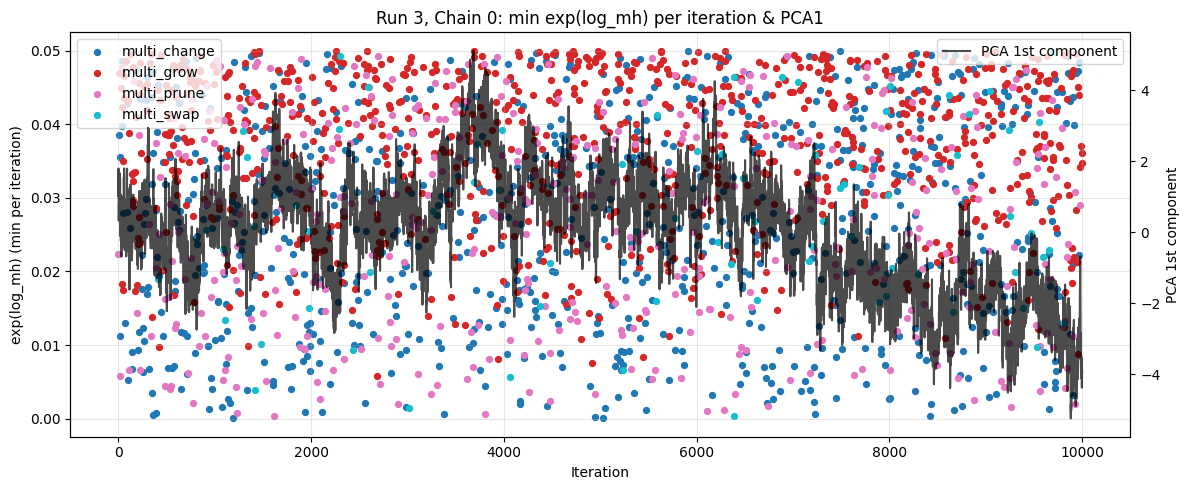

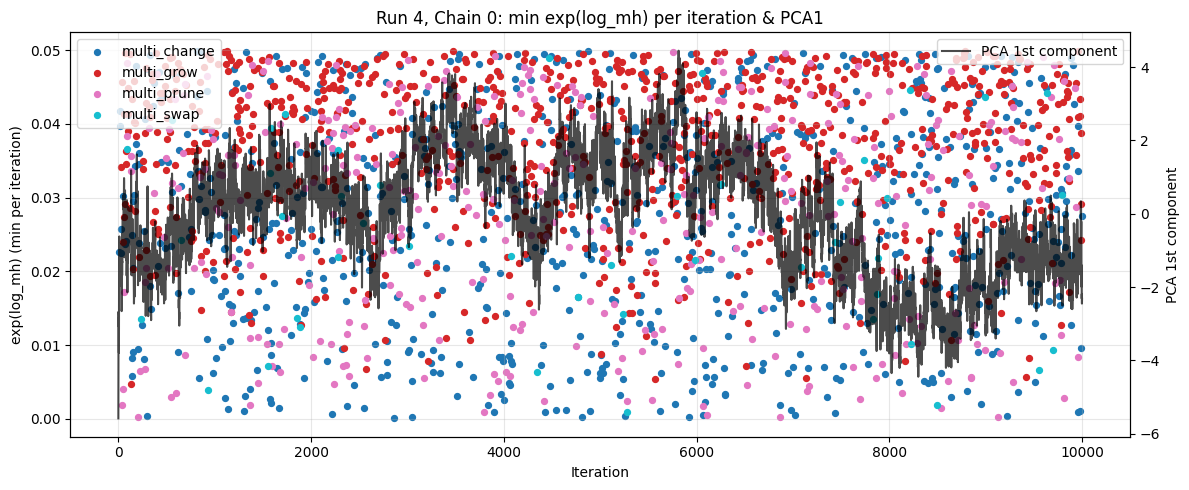

In [11]:
experiment_results = np.load(f'store/{notebook}.npz', allow_pickle=True)
mtmh_data = experiment_results['mtmh'].item()
accepted_moves_logmh = mtmh_data['accepted_moves_logmh']
preds = mtmh_data['preds']

plot_moves_and_pca(
    accepted_moves_logmh,
    preds,
    threshold=0.05,
    agg_method='min',
    n_components=5,
    chain_id=0
)

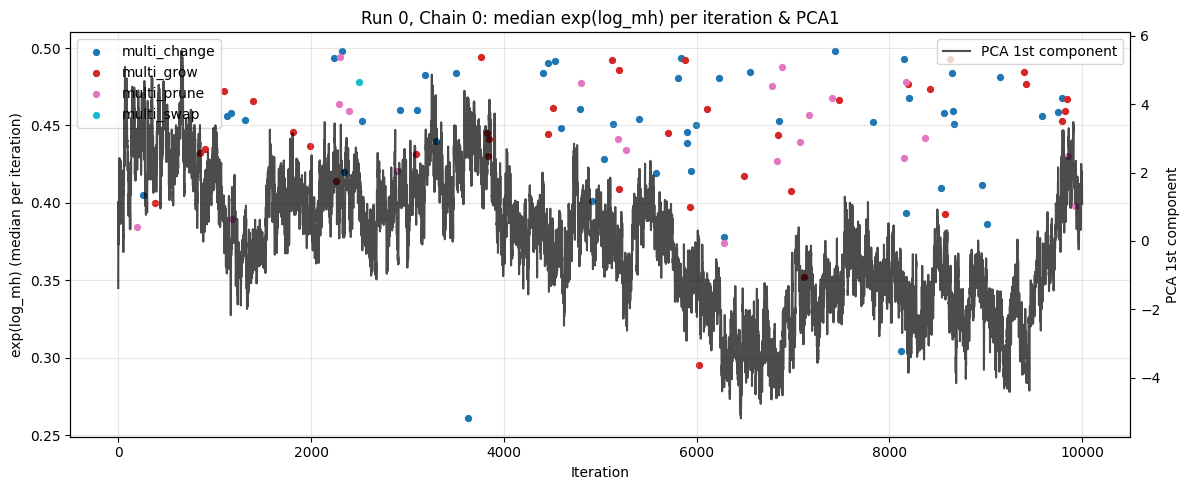

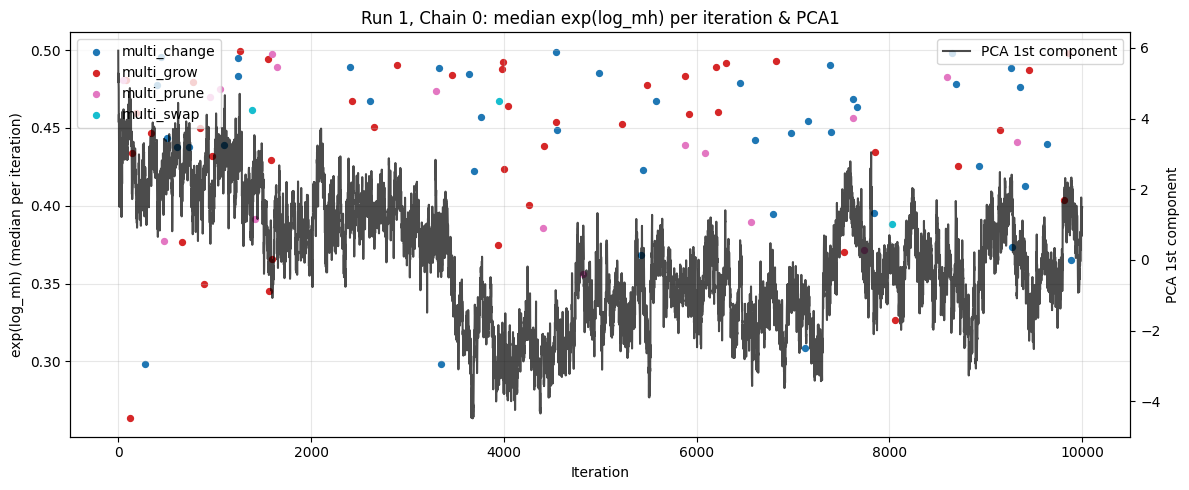

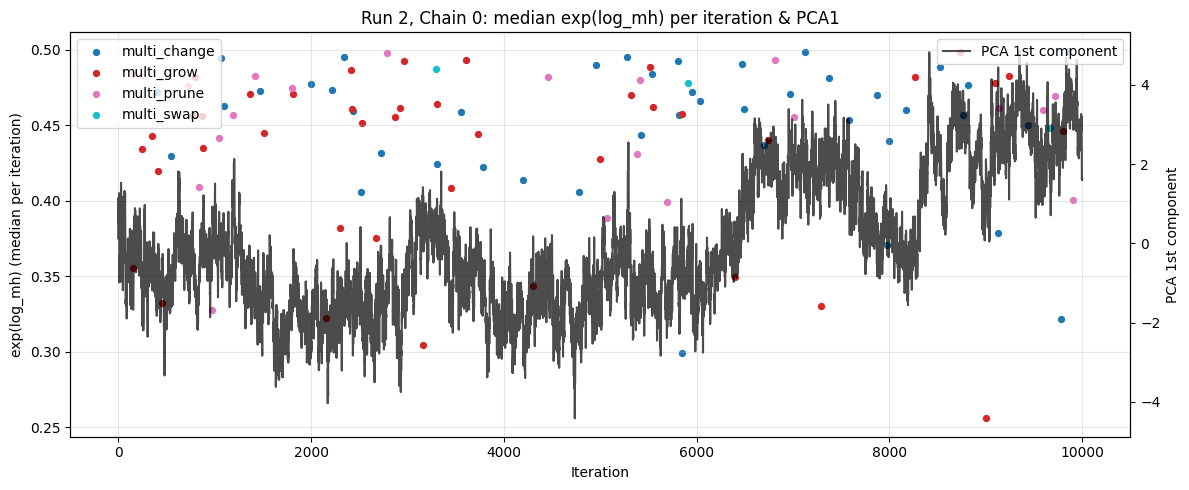

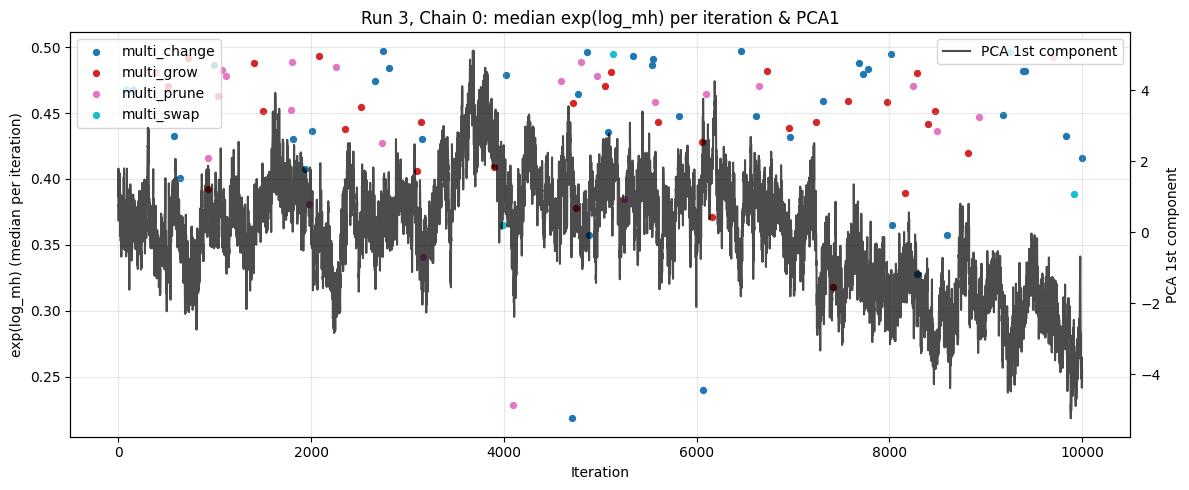

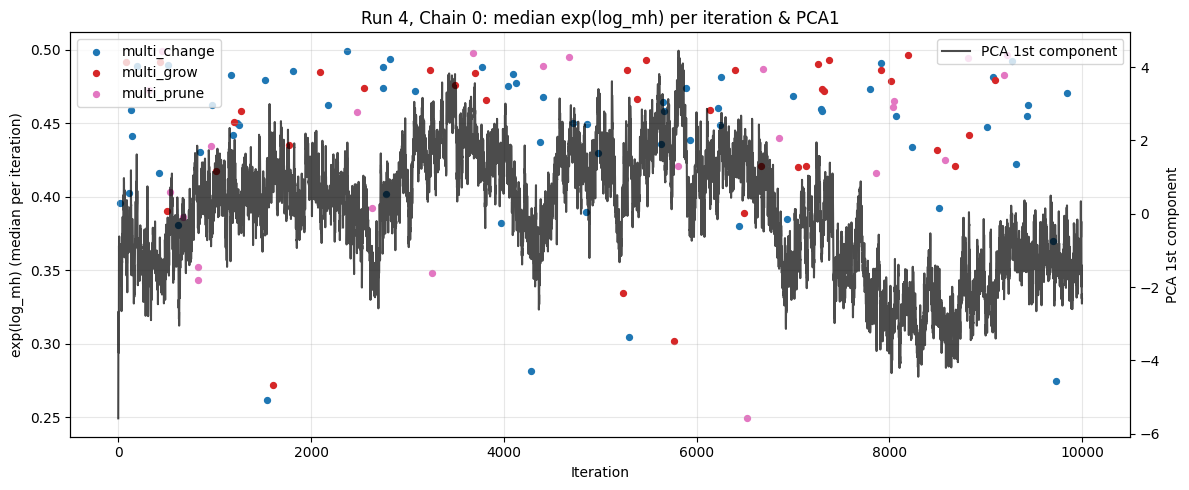

In [12]:
experiment_results = np.load(f'store/{notebook}.npz', allow_pickle=True)
mtmh_data = experiment_results['mtmh'].item()
accepted_moves_logmh = mtmh_data['accepted_moves_logmh']
preds = mtmh_data['preds']

plot_moves_and_pca(
    accepted_moves_logmh,
    preds,
    threshold=0.5,
    agg_method='median',
    n_components=5,
    chain_id=0
)

# KPSS Test

## Preds (PCA)

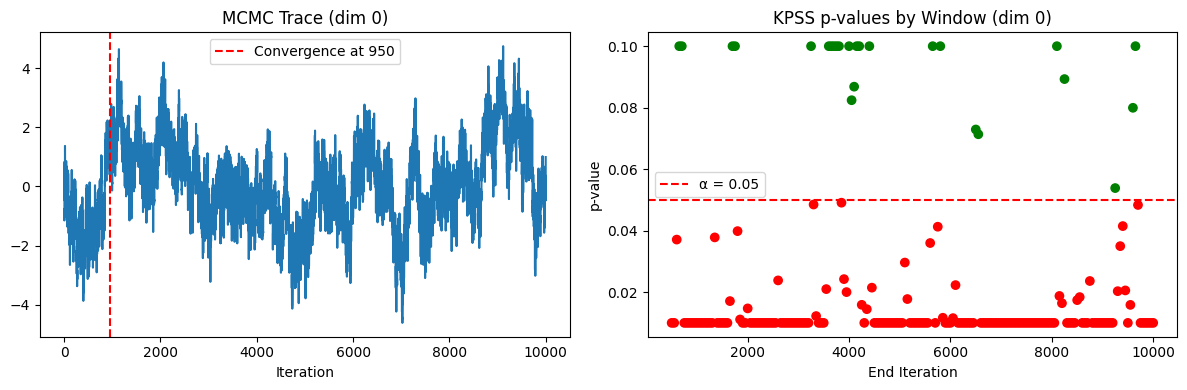

Run 0: convergence_iter = 950


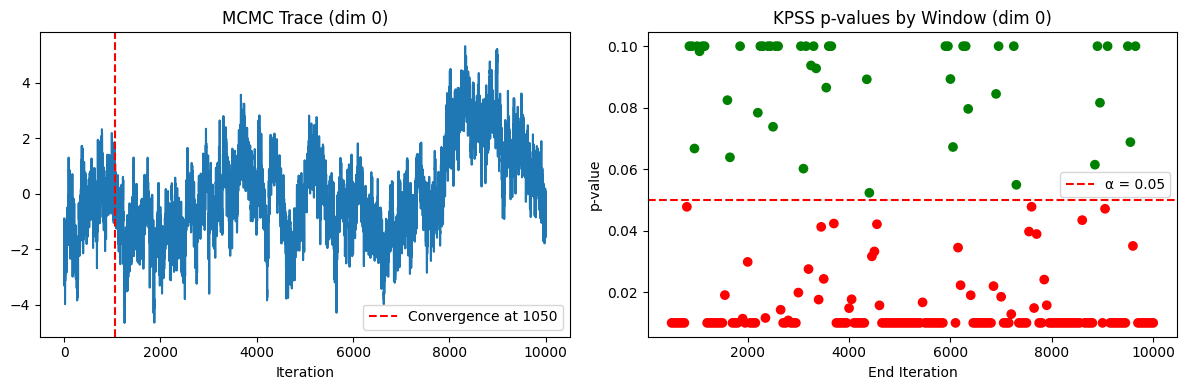

Run 1: convergence_iter = 1050


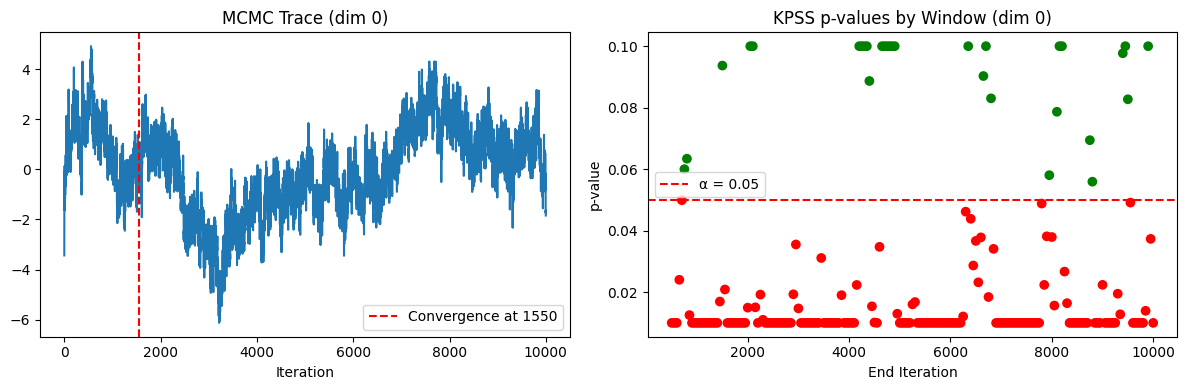

Run 2: convergence_iter = 1550


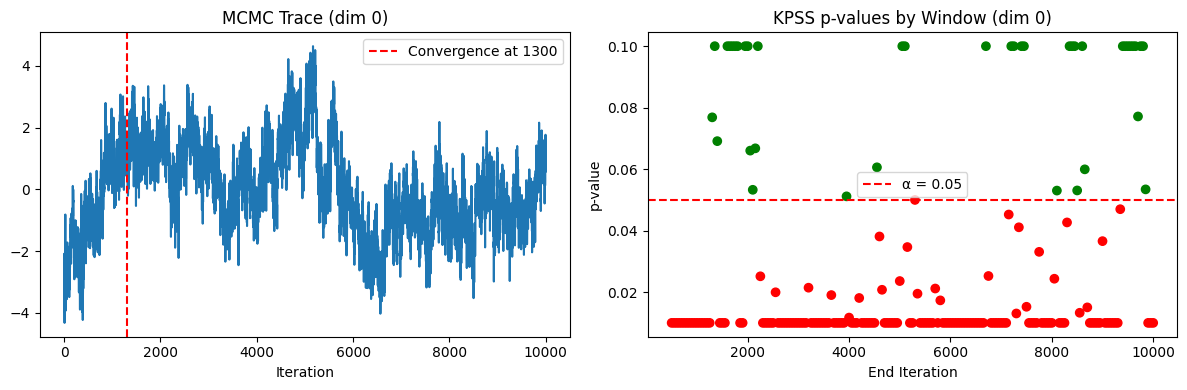

Run 3: convergence_iter = 1300


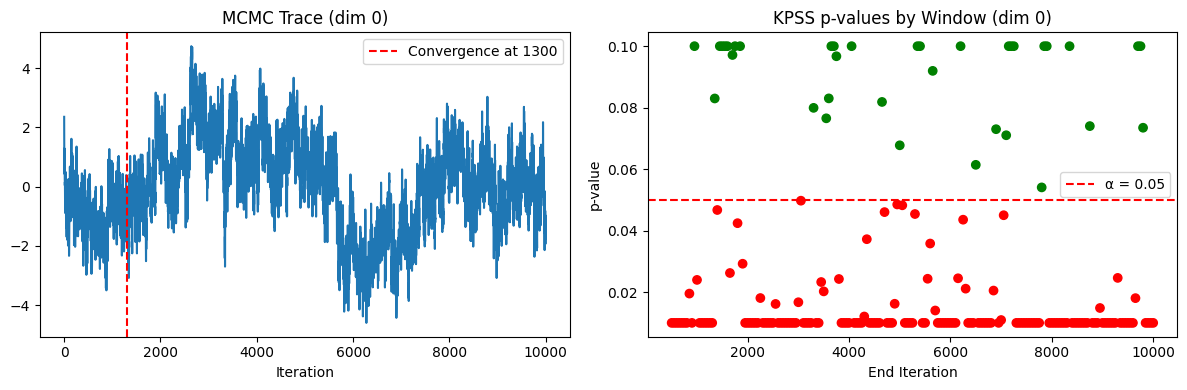

Run 4: convergence_iter = 1300
All runs convergence_iter: [950, 1050, 1550, 1300, 1300]


In [13]:
import numpy as np
from diagnosis import segmented_kpss_test
from sklearn.decomposition import PCA

# default
preds = experiment_results['default'].item()['preds']  # shape: [n_runs, n_chains, n_test_points, n_iter]
n_runs, n_chains, n_test_points, n_iter = preds.shape

window_size = 500
step = 50
alpha = 0.05

convergence_iters = []
for run_id in range(n_runs):
    # shape: [n_test_points, n_iter]
    chain_preds = preds[run_id, 0].T  # [n_iter, n_test_points]
    chain_preds_centered = chain_preds - np.mean(chain_preds, axis=0)
    pca = PCA(n_components=5)
    chain_preds_pca = pca.fit_transform(chain_preds_centered)
    result = segmented_kpss_test(chain_preds_pca, window_size=window_size, step=step, alpha=alpha)
    convergence_iters.append(result['convergence_iteration'])
    print(f"Run {run_id}: convergence_iter = {result['convergence_iteration']}")

print("All runs convergence_iter:", convergence_iters)

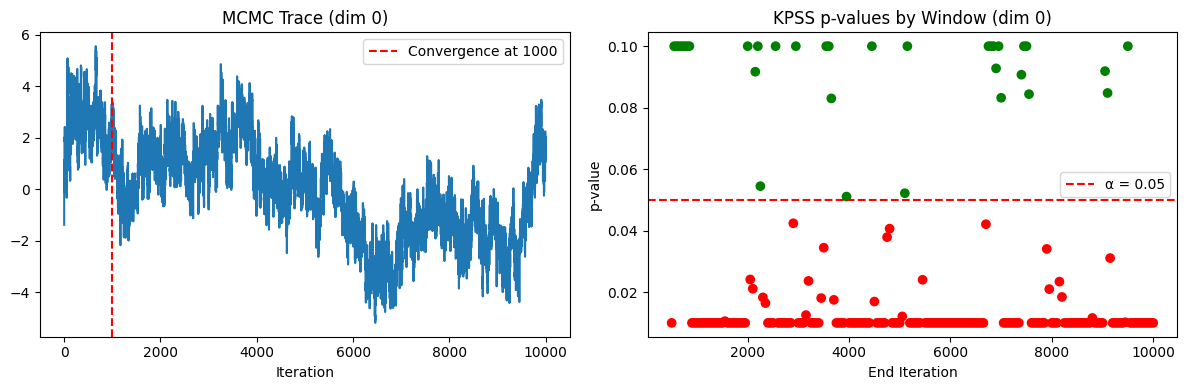

Run 0: convergence_iter = 1000


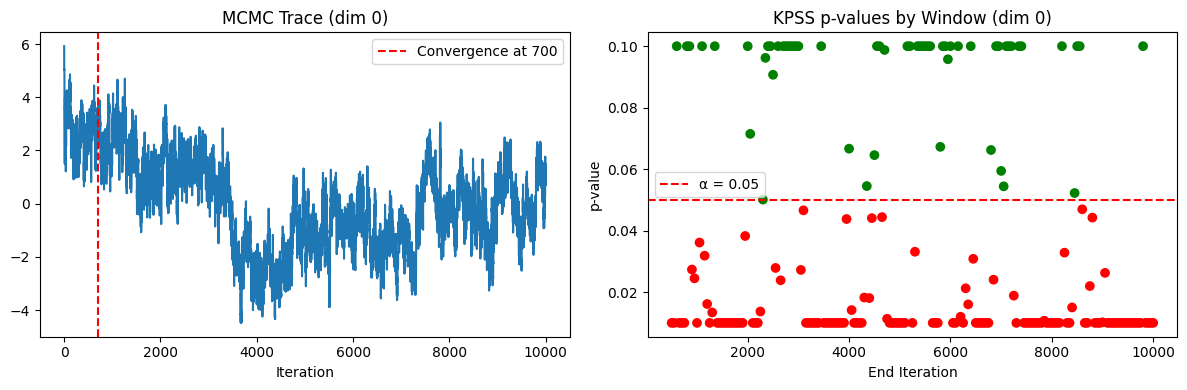

Run 1: convergence_iter = 700


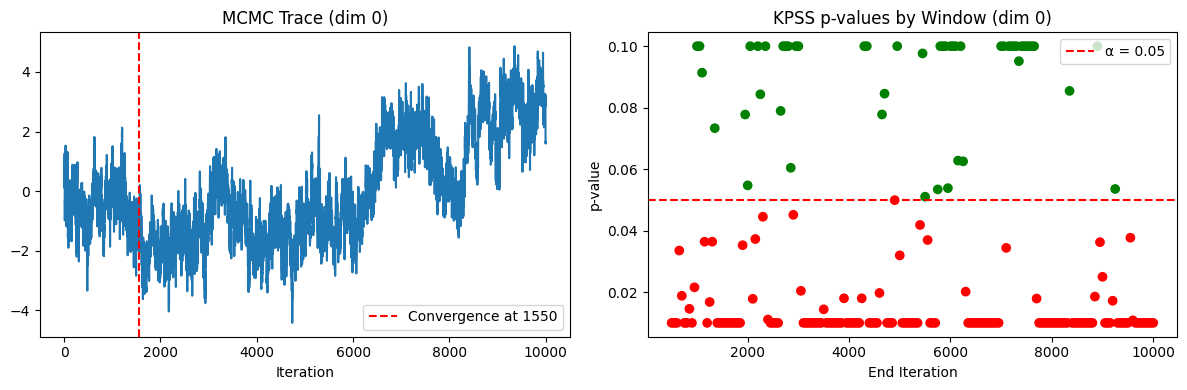

Run 2: convergence_iter = 1550


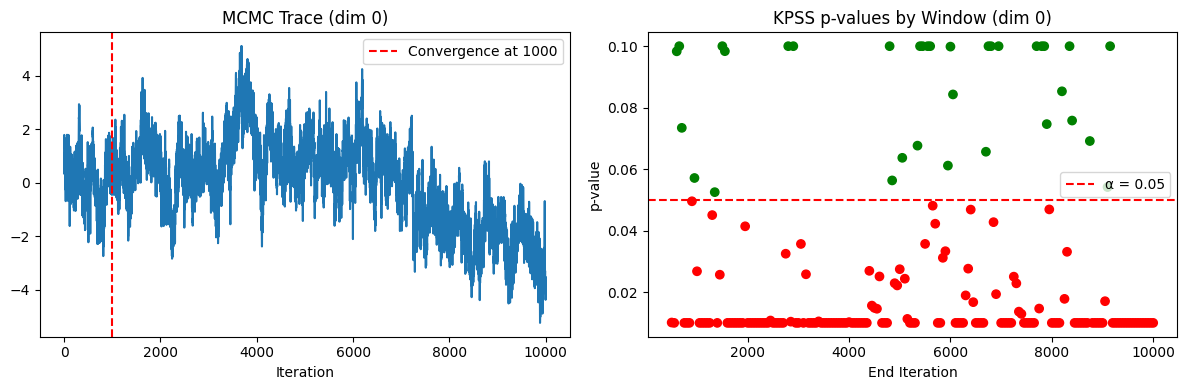

Run 3: convergence_iter = 1000


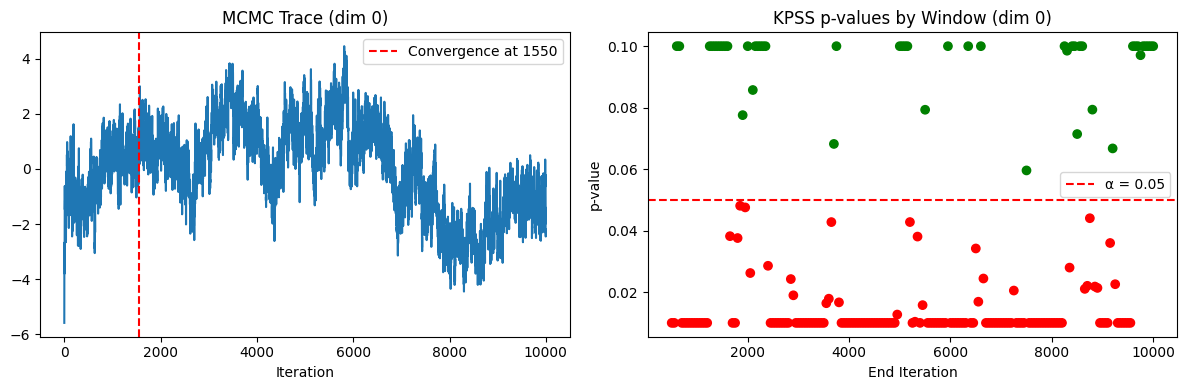

Run 4: convergence_iter = 1550
All runs convergence_iter: [1000, 700, 1550, 1000, 1550]


In [14]:
import numpy as np
from diagnosis import segmented_kpss_test
from sklearn.decomposition import PCA

# mtmh
preds = experiment_results['mtmh'].item()['preds']  # shape: [n_runs, n_chains, n_test_points, n_iter]
n_runs, n_chains, n_test_points, n_iter = preds.shape

window_size = 500
step = 50
alpha = 0.05

convergence_iters = []
for run_id in range(n_runs):
    # shape: [n_test_points, n_iter]
    chain_preds = preds[run_id, 0].T  # [n_iter, n_test_points]
    chain_preds_centered = chain_preds - np.mean(chain_preds, axis=0)
    pca = PCA(n_components=5)
    chain_preds_pca = pca.fit_transform(chain_preds_centered)
    result = segmented_kpss_test(chain_preds_pca, window_size=window_size, step=step, alpha=alpha)
    convergence_iters.append(result['convergence_iteration'])
    print(f"Run {run_id}: convergence_iter = {result['convergence_iteration']}")

print("All runs convergence_iter:", convergence_iters)

# Rhat (preds)

INFO:arviz.preview:arviz_base not installed
INFO:arviz.preview:arviz_stats not installed
INFO:arviz.preview:arviz_plots not installed


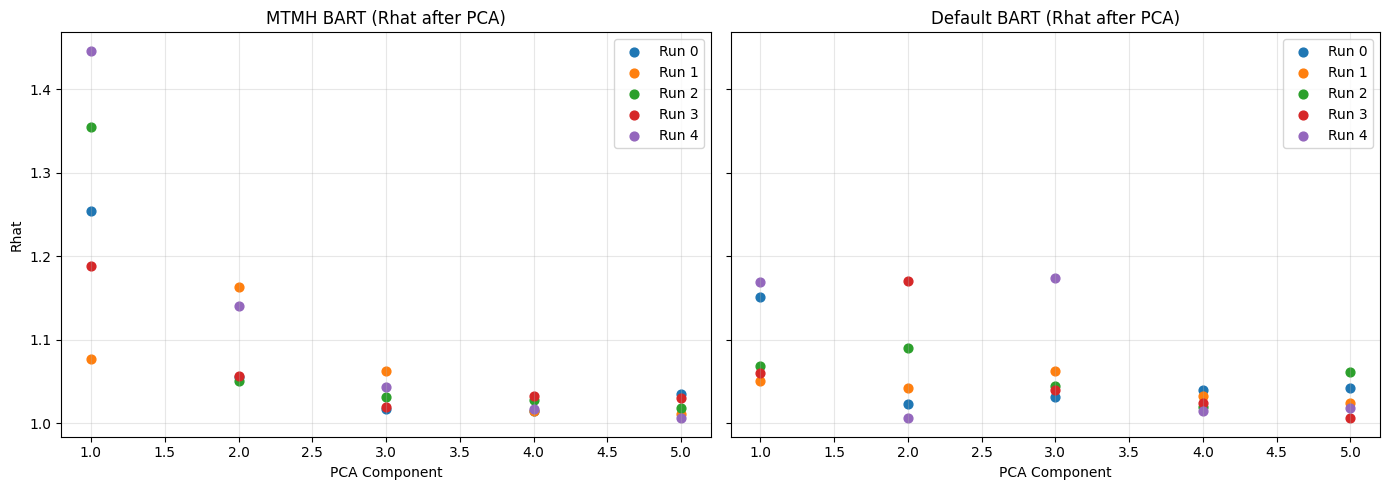

In [15]:
import numpy as np
import arviz as az
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def compute_rhat_pca_per_run(preds, n_components=5):
    n_runs, n_chains, n_test_points, n_iter = preds.shape
    rhat_all = []
    for run_id in range(n_runs):
        # [n_chains, n_test_points, n_iter] -> [n_chains, n_iter, n_test_points]
        x = preds[run_id, :, :, 3000:]
        x = np.transpose(x, (0, 2, 1))
        # Do PCA for each chain
        pca = PCA(n_components=n_components)
        z = np.array([pca.fit_transform(x_chain) for x_chain in x])  # [n_chains, n_iter, n_components]
        rhat_run = []
        for k in range(n_components):
            # z[:, :, k]: [n_chains, n_iter] for component k
            rhat_val = az.rhat(z[:, :, k])
            rhat_run.append(rhat_val)
        rhat_all.append(rhat_run)
    return np.array(rhat_all)  # [n_runs, n_components]

# Compute Rhat after PCA for default and mtmh
preds_default = experiment_results['default'].item()['preds']
preds_mtmh = experiment_results['mtmh'].item()['preds']

rhat_default_pca = compute_rhat_pca_per_run(preds_default)
rhat_mtmh_pca = compute_rhat_pca_per_run(preds_mtmh)
n_runs, n_components = rhat_default_pca.shape

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Left: MTMH
for run_id in range(n_runs):
    axes[0].scatter(np.arange(1, n_components+1), rhat_mtmh_pca[run_id], label=f'Run {run_id}', s=40)
axes[0].set_xlabel('PCA Component')
axes[0].set_ylabel('Rhat')
axes[0].set_title('MTMH BART (Rhat after PCA)')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Right: Default
for run_id in range(n_runs):
    axes[1].scatter(np.arange(1, n_components+1), rhat_default_pca[run_id], label=f'Run {run_id}', s=40)
axes[1].set_xlabel('PCA Component')
axes[1].set_title('Default BART (Rhat after PCA)')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# ESS (preds)

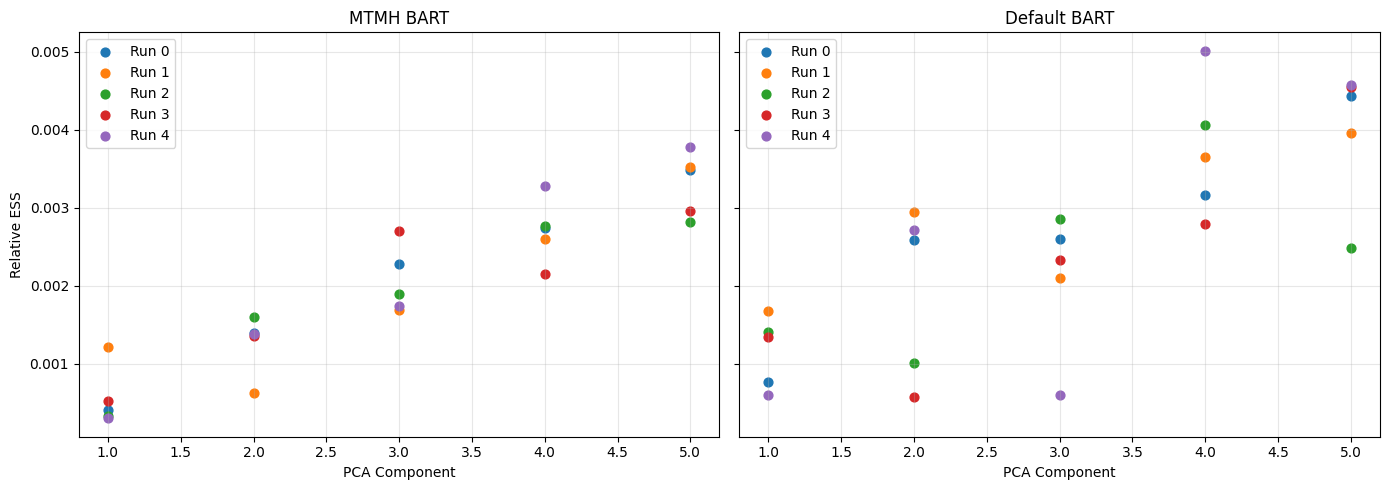

In [16]:
import numpy as np
from arviz.stats import ess
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def compute_ess_per_run(preds):
    n_runs, n_chains, n_test_points, n_iter = preds.shape
    ess_all = []
    for run_id in range(n_runs):
        x = preds[run_id, :, :, 3000:]  # [n_chains, n_test_points, n_iter]
        x = np.transpose(x, (0, 2, 1))  # [n_chains, n_iter, n_test_points]
        pca = PCA(n_components=5)
        z = np.array([pca.fit_transform(x_chain) for x_chain in x])  # [n_chains, n_iter, 5]
        ess_run = []
        for k in range(z.shape[2]):
            ess_val = ess(z[:, :, k], relative=True)
            ess_run.append(ess_val)
        ess_all.append(ess_run)
    return np.array(ess_all)  # [n_runs, 5]

# Compute ESS for default and mtmh
preds_default = experiment_results['default'].item()['preds']
preds_mtmh = experiment_results['mtmh'].item()['preds']

ess_default = compute_ess_per_run(preds_default)
ess_mtmh = compute_ess_per_run(preds_mtmh)

n_runs, n_components = ess_default.shape

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Left: MTMH
for run_id in range(n_runs):
    axes[0].scatter(np.arange(1, n_components+1), ess_mtmh[run_id], label=f'Run {run_id}', s=40)
axes[0].set_xlabel('PCA Component')
axes[0].set_ylabel('Relative ESS')
axes[0].set_title('MTMH BART')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Right: Default
for run_id in range(n_runs):
    axes[1].scatter(np.arange(1, n_components+1), ess_default[run_id], label=f'Run {run_id}', s=40)
axes[1].set_xlabel('PCA Component')
axes[1].set_title('Default BART')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Autocorrelation Plot (preds)

=== Default BART Analysis ===

--- Run 0 ---
Default PCA first component autocorrelation plot:


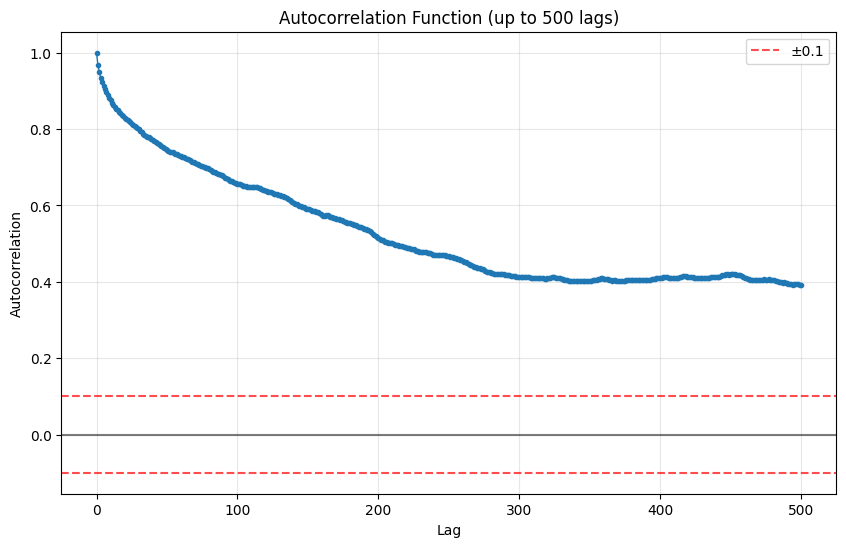


--- Run 1 ---
Default PCA first component autocorrelation plot:


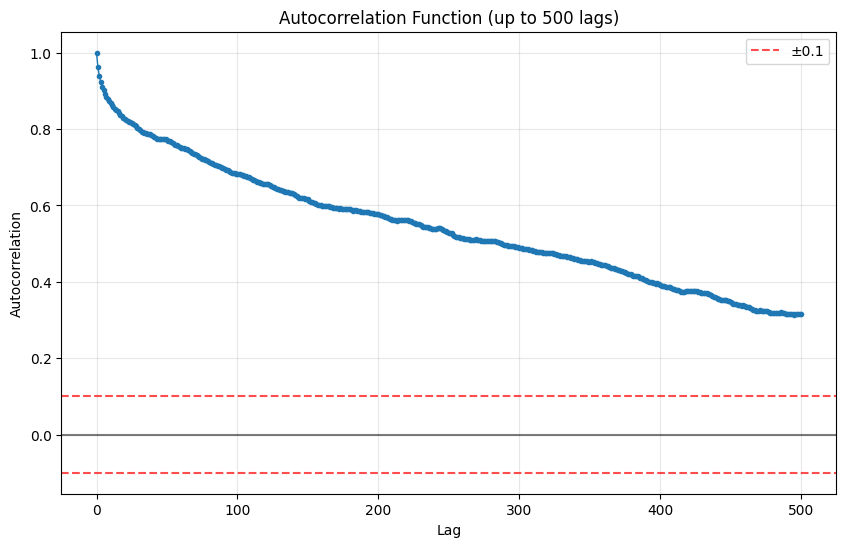


--- Run 2 ---
Default PCA first component autocorrelation plot:


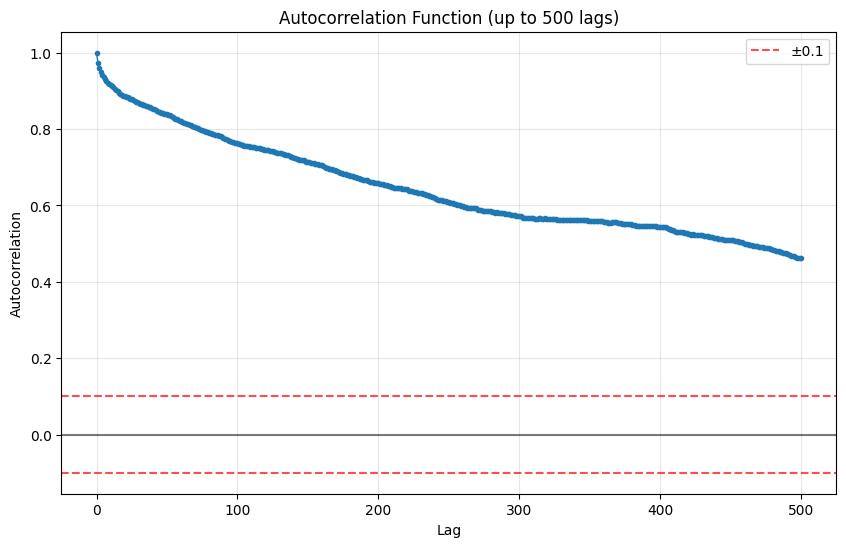


--- Run 3 ---
Default PCA first component autocorrelation plot:


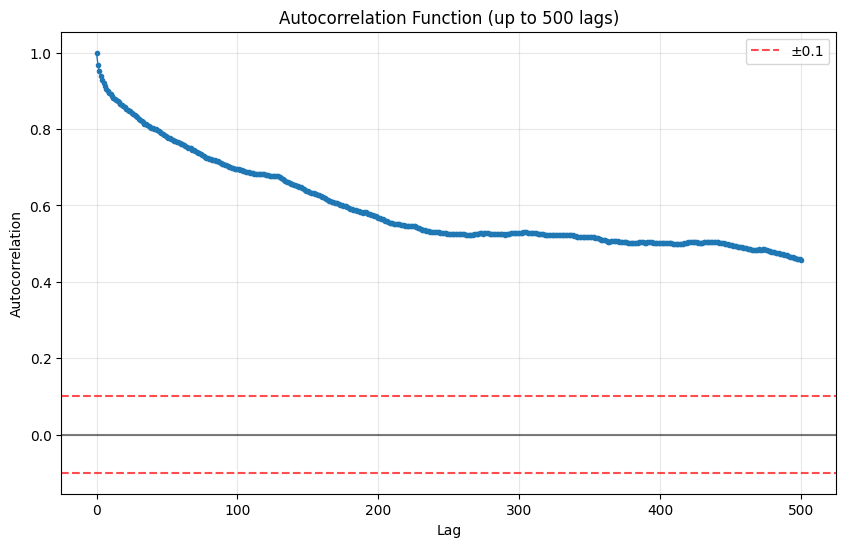


--- Run 4 ---
Default PCA first component autocorrelation plot:


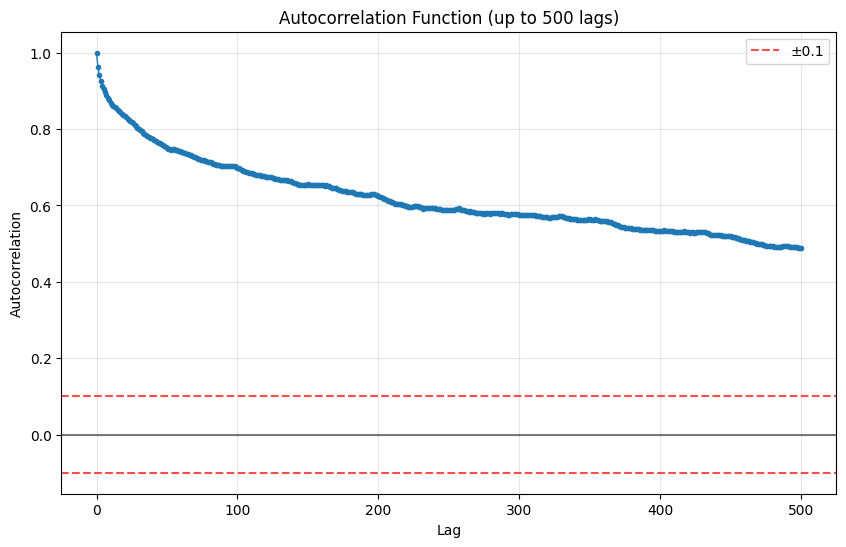

In [17]:
from diagnosis import plot_autocorrelation
from sklearn.decomposition import PCA
# Analyze each run's results
n_runs = 5

# Analyze Default BART results
print("=== Default BART Analysis ===")
for run_id in range(n_runs):
    print(f"\n--- Run {run_id} ---")
    
    # Extract data for this run
    preds = experiment_results['default'].item()['preds'][run_id, 0, :, 3000:]  # [n_test_points, n_iter]
    pred0 = preds[0, :]  # First test point
    x = np.transpose(preds, (1, 0))  # [n_iter, n_test_points]
    pca = PCA(n_components=5)
    z = pca.fit_transform(x)  # [n_iter, n_components]
    pca0 = z[:, 0]  # First PCA component

    # print(f"Default first pred autocorrelation plot:")
    # plot_autocorrelation(pred0, nlags=500)

    print(f"Default PCA first component autocorrelation plot:")
    plot_autocorrelation(pca0, nlags=500)

=== MTMH BART Analysis ===

--- Run 0 ---
MTMH PCA first component autocorrelation plot:


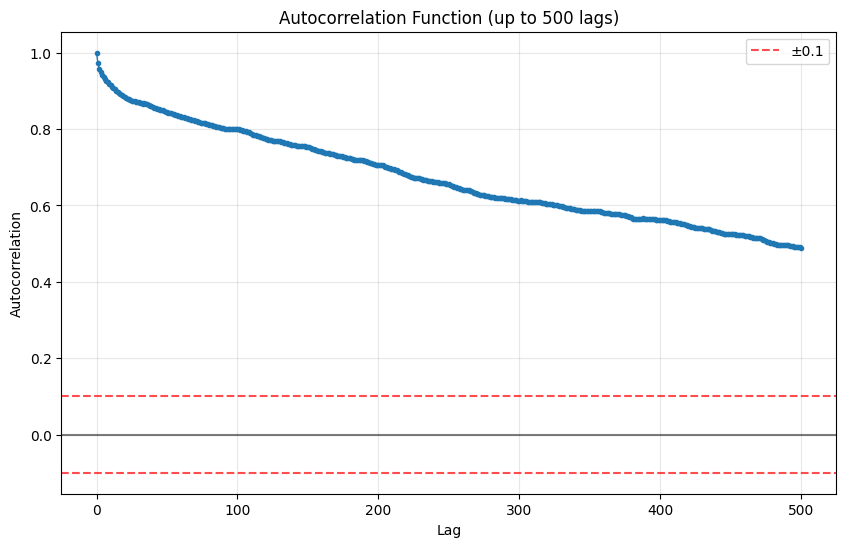


--- Run 1 ---
MTMH PCA first component autocorrelation plot:


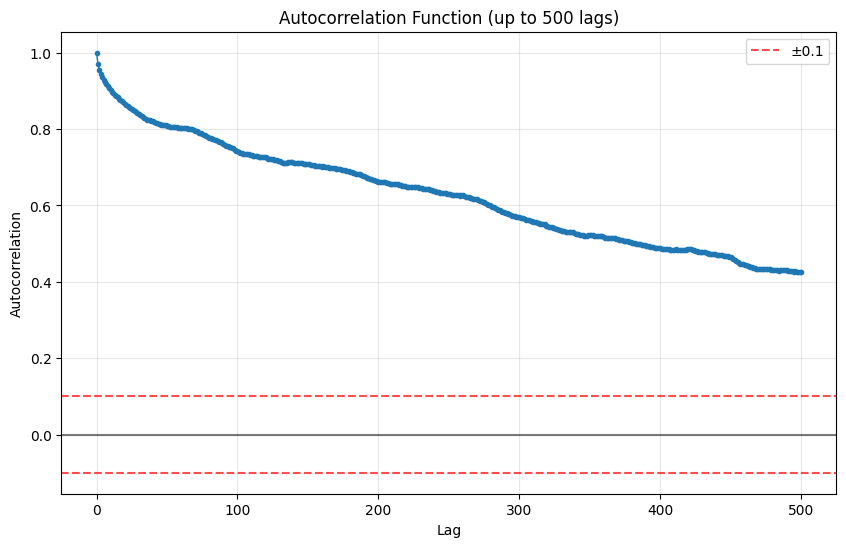


--- Run 2 ---
MTMH PCA first component autocorrelation plot:


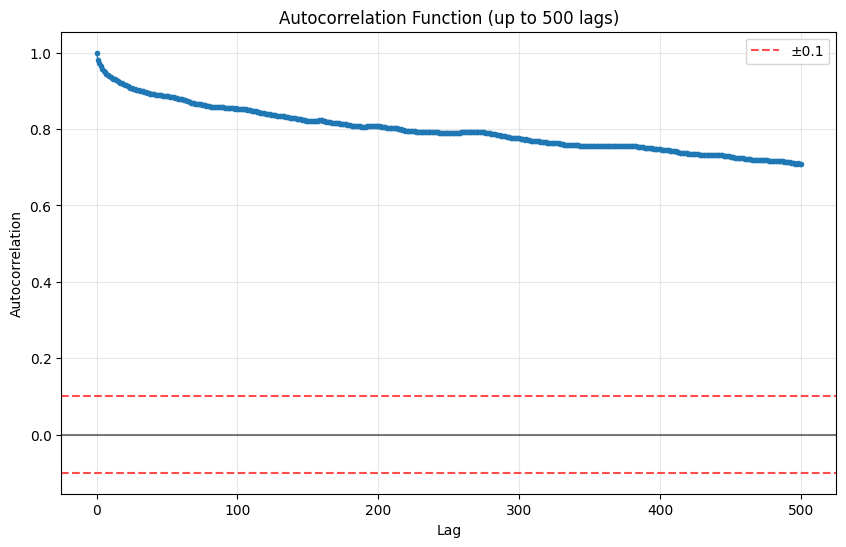


--- Run 3 ---
MTMH PCA first component autocorrelation plot:


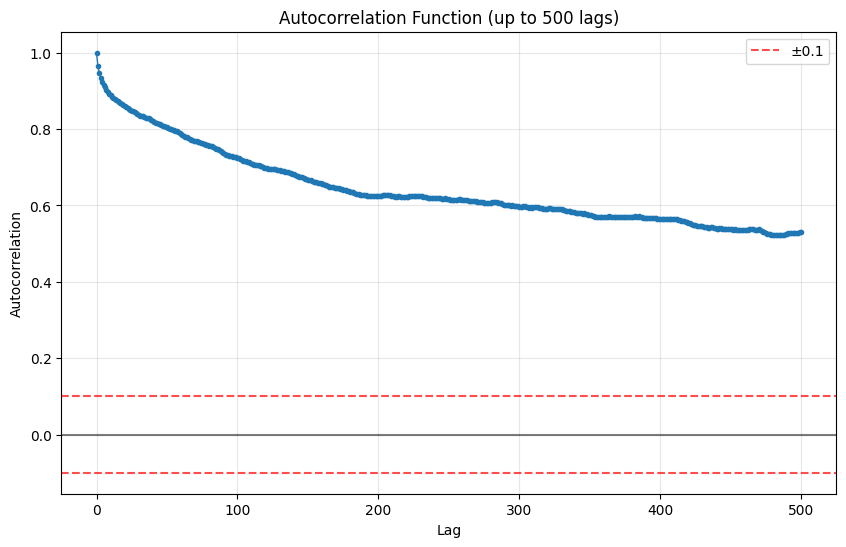


--- Run 4 ---
MTMH PCA first component autocorrelation plot:


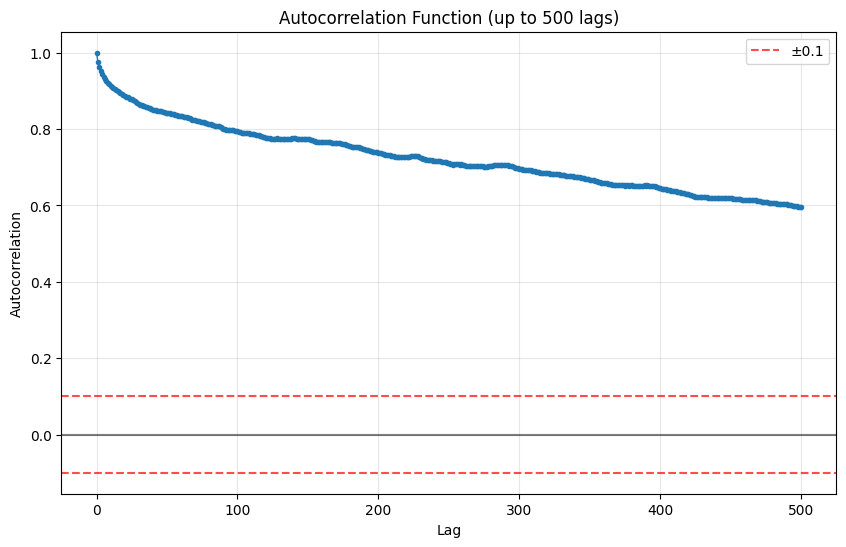

In [18]:
from diagnosis import plot_autocorrelation
from sklearn.decomposition import PCA
# Analyze each run's results
n_runs = 5

# Analyze MTMH BART results
print("=== MTMH BART Analysis ===")
for run_id in range(n_runs):
    print(f"\n--- Run {run_id} ---")
    
    # Extract data for this run
    preds = experiment_results['mtmh'].item()['preds'][run_id, 0, :, 3000:]  # [n_test_points, n_iter]
    pred0 = preds[0, :]  # First test point
    x = np.transpose(preds, (1, 0))  # [n_iter, n_test_points]
    pca = PCA(n_components=5)
    z = pca.fit_transform(x)  # [n_iter, n_components]
    pca0 = z[:, 0]  # First PCA component

    # print(f"MTMH first pred autocorrelation plot:")
    # plot_autocorrelation(pred0, nlags=500)

    print(f"MTMH PCA first component autocorrelation plot:")
    plot_autocorrelation(pca0, nlags=500)

# PCA Loadings

In [19]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Use default preds as in previous cells
preds_default = experiment_results['default'].item()['preds']  # [n_runs, n_chains, n_test_points, n_iter]
n_runs, n_chains, n_test_points, n_iter = preds_default.shape

# Settings
burnin = 3000          # discard first iterations
n_components = 5       # PCA components to keep
n_pcs_for_score = 2    # how many leading PCs to use when scoring test points
top_k = 10             # how many most problematic test points to report

all_problematic_indices = []
all_problematic_scores = []

print("=== PCA loadings analysis on test points (default, first chain of each run) ===")

for run_id in range(n_runs):
    # Take first chain of this run and drop burn-in
    # Shape before burn-in: [n_chains, n_test_points, n_iter]
    chain_preds = preds_default[run_id, 0, :, burnin:]  # [n_test_points, n_iter]
    
    # We want a matrix [n_iter_eff, n_test_points] where columns are test points
    X = chain_preds.T  # [n_iter_eff, n_test_points]
    
    # Center by column (test point)
    # X = X - X.mean(axis=0)
    
    # PCA on test points (features = test points)
    pca = PCA(n_components=n_components)
    scores = pca.fit_transform(X)  # scores shape: [n_iter_eff, n_components]
    loadings = pca.components_             # shape: [n_components, n_test_points]
    
    # Use the first n_pcs_for_score PCs to compute a "problem score" for each test point
    # Here we use the sum of squared loadings across these PCs
    used_loadings = loadings[:n_pcs_for_score, :]        # [n_pcs_for_score, n_test_points]
    point_scores = np.sum(used_loadings ** 2, axis=0)    # [n_test_points]
    
    # Sort test points by score (descending)
    sorted_idx = np.argsort(point_scores)[::-1]
    all_problematic_indices.append(sorted_idx[:top_k])
    all_problematic_scores.append(point_scores)
    
    print(f"\nRun {run_id}:")
    print(f"  Explained variance ratio (first {n_pcs_for_score} PCs): "
          f"{np.round(pca.explained_variance_ratio_[:n_pcs_for_score], 4)}, "
          f"sum = {np.round(np.sum(pca.explained_variance_ratio_[:n_pcs_for_score]), 4)}")
    
    print(f"  Top {top_k} potentially problematic test points (index, score):")
    for rank, idx in enumerate(sorted_idx[:top_k], start=1):
        print(f"    #{rank}: test_point {idx}, score = {point_scores[idx]:.6f}")

all_problematic_indices = np.array(all_problematic_indices)   # [n_runs, top_k]
all_problematic_scores = np.array(all_problematic_scores)     # [n_runs, n_test_points]

=== PCA loadings analysis on test points (default, first chain of each run) ===

Run 0:
  Explained variance ratio (first 2 PCs): [0.0531 0.0496], sum = 0.1027
  Top 10 potentially problematic test points (index, score):
    #1: test_point 26, score = 0.163581
    #2: test_point 58, score = 0.133877
    #3: test_point 90, score = 0.113260
    #4: test_point 71, score = 0.089711
    #5: test_point 40, score = 0.079924
    #6: test_point 46, score = 0.059024
    #7: test_point 86, score = 0.049813
    #8: test_point 95, score = 0.048532
    #9: test_point 31, score = 0.048277
    #10: test_point 69, score = 0.048141

Run 1:
  Explained variance ratio (first 2 PCs): [0.0605 0.0509], sum = 0.1114
  Top 10 potentially problematic test points (index, score):
    #1: test_point 46, score = 0.203762
    #2: test_point 1, score = 0.182964
    #3: test_point 88, score = 0.131505
    #4: test_point 79, score = 0.127945
    #5: test_point 29, score = 0.083470
    #6: test_point 60, score = 0.08346

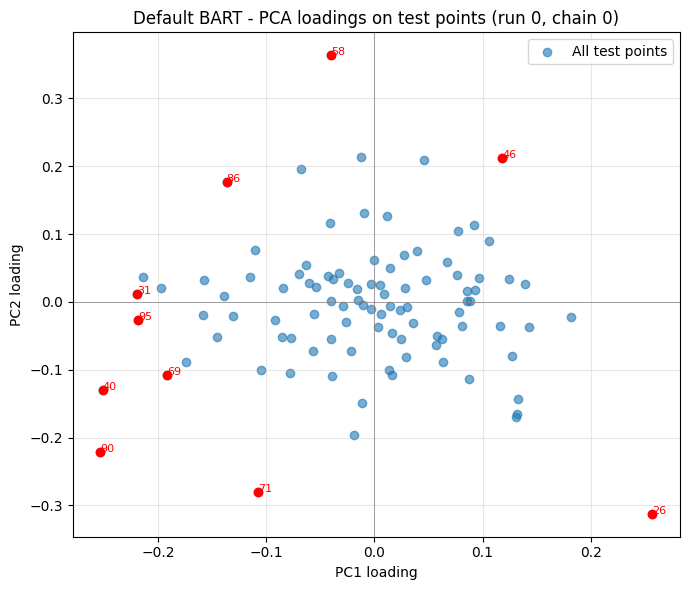

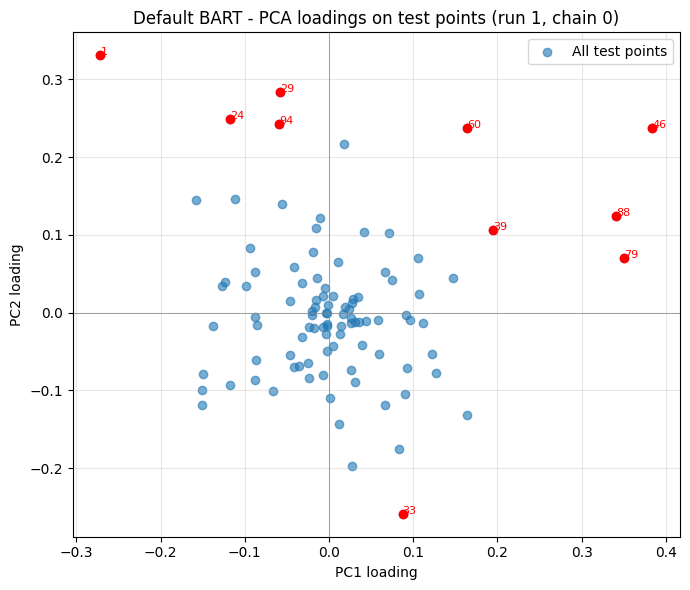

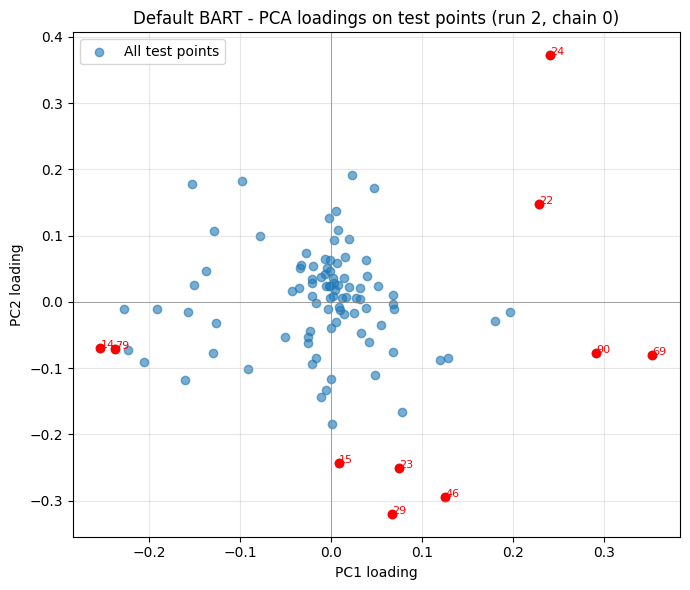

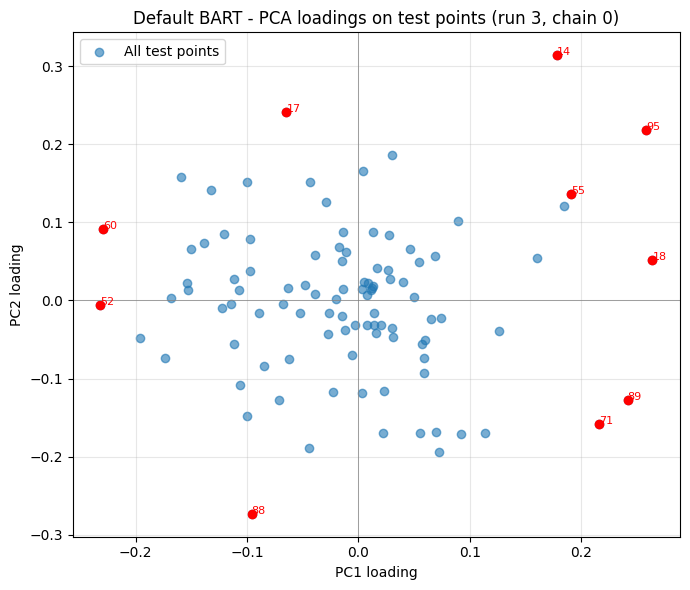

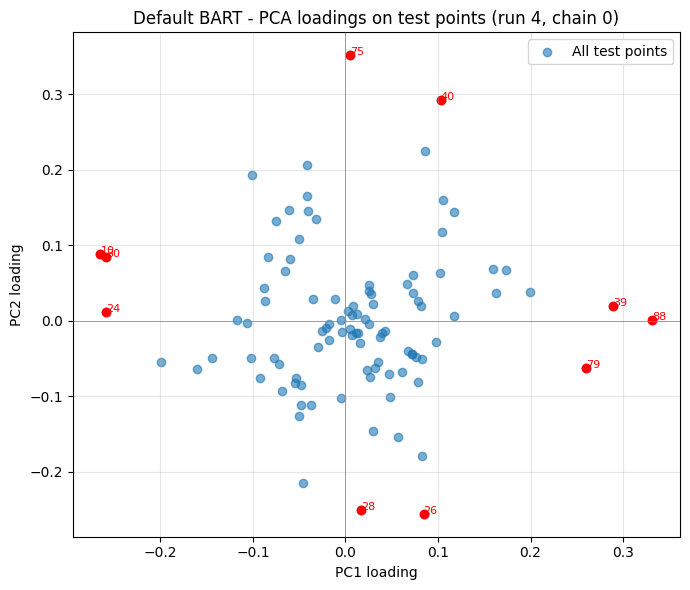

In [20]:
for run_id in range(n_runs):
    run_to_plot = run_id
    chain_preds_plot = preds_default[run_to_plot, 0, :, burnin:]   # [n_test_points, n_iter]
    X_plot = chain_preds_plot.T
    X_plot_centered = X_plot - X_plot.mean(axis=0)

    pca_plot = PCA(n_components=n_components)
    _ = pca_plot.fit_transform(X_plot_centered)
    loadings_2d = pca_plot.components_[:2, :]  # first two PCs: [2, n_test_points]

    plt.figure(figsize=(7, 6))
    plt.scatter(loadings_2d[0, :], loadings_2d[1, :], alpha=0.6, label="All test points")

    # Highlight problematic points for this run
    for idx in all_problematic_indices[run_to_plot]:
        plt.scatter(loadings_2d[0, idx], loadings_2d[1, idx], color="red")
        plt.text(loadings_2d[0, idx], loadings_2d[1, idx], str(idx),
                color="red", fontsize=8)

    plt.axhline(0, color="gray", linewidth=0.5)
    plt.axvline(0, color="gray", linewidth=0.5)
    plt.xlabel("PC1 loading")
    plt.ylabel("PC2 loading")
    plt.title(f"Default BART - PCA loadings on test points (run {run_to_plot}, chain 0)")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Multimodality

## Single run, difference chains (with same initialization)

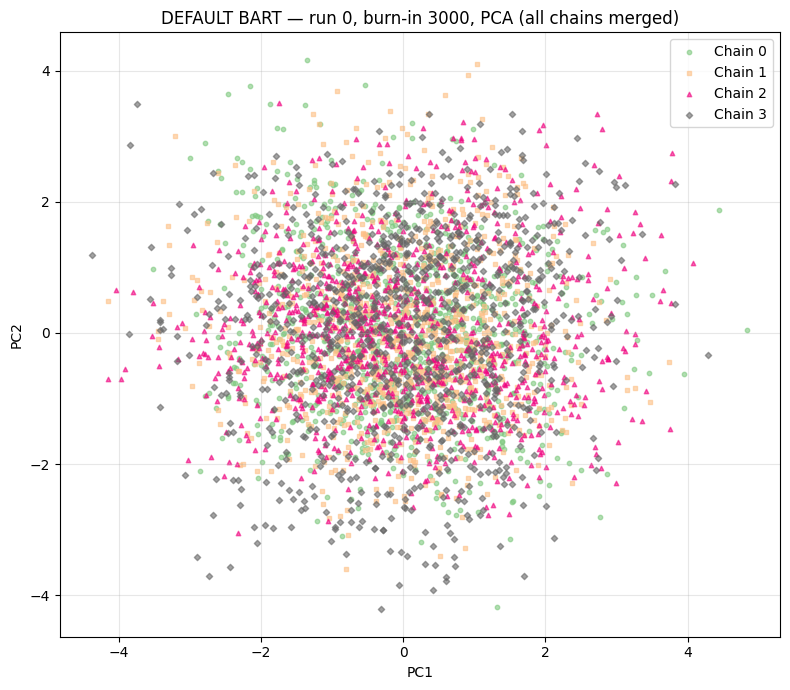

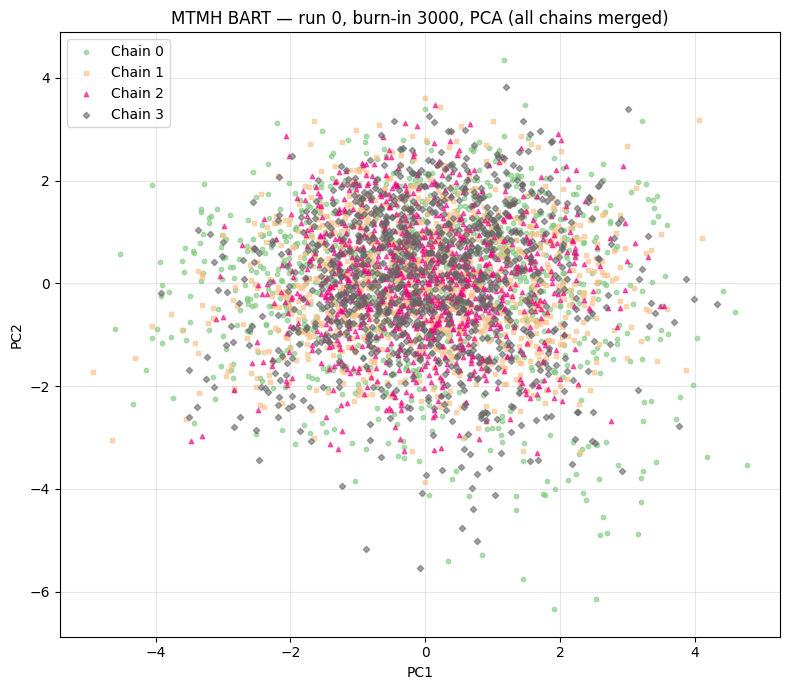

In [7]:
# Multimodality: PCA scatter of chains for a single run
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def scatter_pca_by_chain(experiment_results,
                         which='default',
                         run_id=0,
                         burnin=3000,
                         n_components=2,
                         max_points=1000):
    """
    Plot PC1-PC2 scatter for all chains in a given run.
    - which: 'default' or 'mtmh'
    - run_id: integer run index
    - burnin: number of initial iterations to discard
    - n_components: number of PCA components to compute
    - max_points: subsample iterations per chain for readability
    """
    data = experiment_results[which].item()
    preds = data['preds']  # [n_runs, n_chains, n_test_points, n_iter]
    _, n_chains, _, _ = preds.shape
    preds_run = preds[run_id]  # [n_chains, n_test_points, n_iter]

    # Merge all chains after burn-in
    X_list = []
    chain_labels = []
    for c in range(n_chains):
        X = preds_run[c, :, burnin:].T  # [n_iter_eff, n_test_points]
        Xc = X - X.mean(axis=0)
        X_list.append(Xc)
        chain_labels.extend([c] * Xc.shape[0])
    X_merged = np.vstack(X_list)  # [n_chains * n_iter_eff, n_test_points]
    chain_labels = np.array(chain_labels)

    # PCA
    pca = PCA(n_components=n_components)
    Z = pca.fit_transform(X_merged)  # [total_points, n_components]

    # subsample
    if max_points is not None and Z.shape[0] > max_points*n_chains:
        step = int(np.ceil(Z.shape[0] / (max_points*n_chains)))
        Z_plot = Z[::step]
        chain_labels_plot = chain_labels[::step]
    else:
        Z_plot = Z
        chain_labels_plot = chain_labels

    colors = plt.get_cmap("Accent", n_chains).colors
    markers = ["o", "s", "^", "D", "P"]

    plt.figure(figsize=(8, 7))
    for c in range(n_chains):
        idx = chain_labels_plot == c
        plt.scatter(Z_plot[idx, 0], Z_plot[idx, 1],
                    s=10, alpha=0.6, color=colors[c], marker=markers[c],
                    label=f'Chain {c}')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title(f'{which.upper()} BART — run {run_id}, burn-in {burnin}, PCA (all chains merged)')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# Usage for run_id=0:
# Default BART
scatter_pca_by_chain(experiment_results, which='default', run_id=0, burnin=3000)

# MTMH BART
scatter_pca_by_chain(experiment_results, which='mtmh', run_id=0, burnin=3000)

## Different runs (different initializaions)

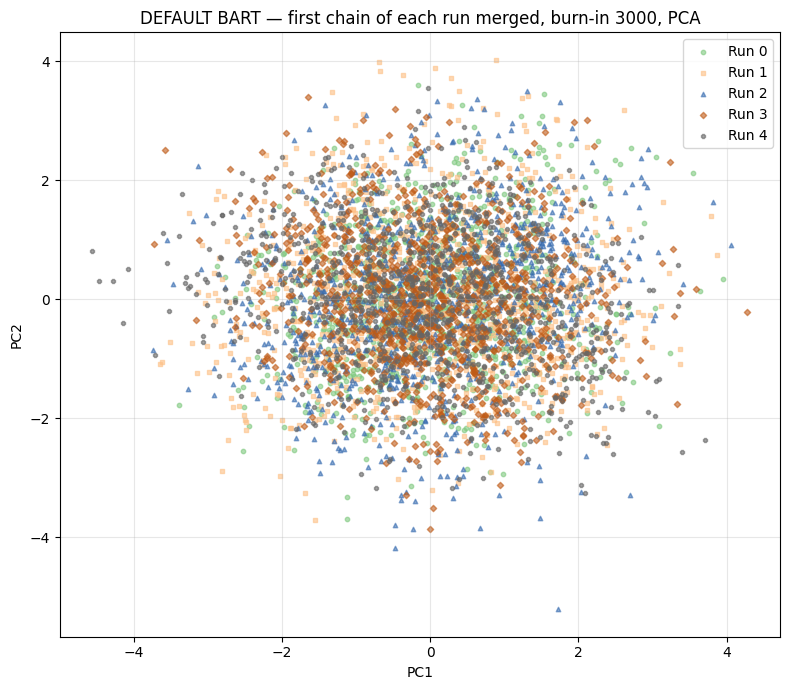

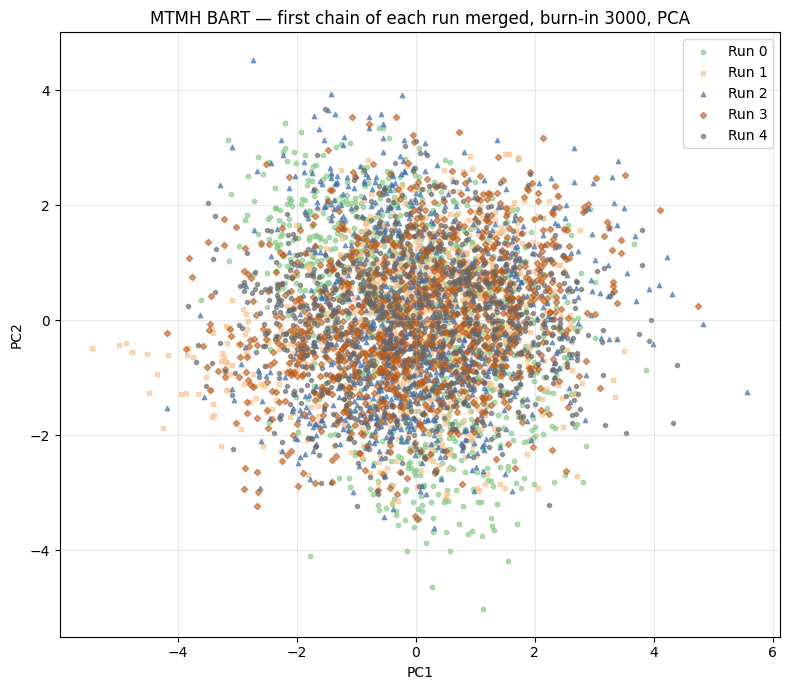

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

def scatter_pca_by_run(experiment_results,
                       which='default',
                       burnin=3000,
                       n_components=2,
                       max_points=1000):
    """
    Merge the first chain of each run after burn-in, perform PCA on the merged data,
    and use different colors to indicate different runs.
    """
    data = experiment_results[which].item()
    preds = data['preds']  # [n_runs, n_chains, n_test_points, n_iter]
    n_runs, n_chains, _, _ = preds.shape

    # Collect all first chains after burn-in
    X_list = []
    run_labels = []
    for run_id in range(n_runs):
        X = preds[run_id, 0, :, burnin:].T  # [n_iter_eff, n_test_points]
        Xc = X - X.mean(axis=0)
        X_list.append(Xc)
        run_labels.extend([run_id] * Xc.shape[0])
    X_merged = np.vstack(X_list)  # [n_runs * n_iter_eff, n_test_points]
    run_labels = np.array(run_labels)

    # PCA on merged data
    pca = PCA(n_components=n_components)
    Z = pca.fit_transform(X_merged)  # [total_points, n_components]

    # Optional subsampling for plotting clarity
    if max_points is not None and Z.shape[0] > max_points * n_runs:
        step = int(np.ceil(Z.shape[0] / (max_points * n_runs)))
        Z_plot = Z[::step]
        run_labels_plot = run_labels[::step]
    else:
        Z_plot = Z
        run_labels_plot = run_labels

    colors = plt.get_cmap("Accent", n_runs).colors
    markers = ["o", "s", "^", "D", "P"]

    plt.figure(figsize=(8, 7))
    for run_id in range(n_runs):
        idx = run_labels_plot == run_id
        plt.scatter(Z_plot[idx, 0], Z_plot[idx, 1],
                    s=10, alpha=0.6, color=colors[run_id], marker=markers[run_id % len(markers)],
                    label=f'Run {run_id}')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title(f'{which.upper()} BART — first chain of each run merged, burn-in {burnin}, PCA')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# Example usage:
scatter_pca_by_run(experiment_results, which='default', burnin=3000)
scatter_pca_by_run(experiment_results, which='mtmh', burnin=3000)